<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/Application/Classification_automation_SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install S2query
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0

# !pip install matplotlib==3.5.1

  Created wheel for S2query: filename=S2query-1.0.1-py3-none-any.whl size=13813 sha256=4b22e1ea0774bf46029046f569b417c0169ce5ebd747849ed2a5f0a0a9e582ff
  Stored in directory: /root/.cache/pip/wheels/0d/51/a6/caf5f4d3835487cf1fea19f56dc3537413cb69195a7530ffb0
Successfully built S2query
     |████████████████████████████████| 3.5 MB 28.9 MB/s 
     |████████████████████████████████| 6.6 MB 65.0 MB/s 
     |████████████████████████████████| 880 kB 53.2 MB/s 
     |████████████████████████████████| 596 kB 48.0 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b6a8bd3f78b62234bbaaa65ee16a9f9e9212ccdf4ca4c6a969751a070d08552f
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unin

# Search no Semantic scholar

In [3]:
from itertools import chain
import numpy as np


## Utilizando a API para fazer a busca de dados

In [19]:
from S2query import S2paperAPI

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re
import time


class SearcherAPI():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperAPI()

    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence'+'Deep Learning'",
    placeholder='Type something',
    # description=':',
    disabled=False
)
    # Configura a localizacao dos botoes/textbox
    self.hbox = widgets.HBox([self.search_b, self.search_text])    
    
    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value, n=100, sort = "total-citations", fieldsOfStudy = ['biology'])

    # Guarda os dados achados
    self.data = self.obj.all
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.hbox)

    

result = SearcherAPI()
result()

'general equilibrium'+'macroeconomics'


Searching...
offsets: 
[0]


[_runtime]>> Start searching...
[_extract]>> Took 0.01s
[_runtime]>> Took 4.16s
[get]>> Took 4.26s


In [20]:
result.data.head()

,paperId,url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors
0,6b2130c74fbec4edf2ad158a1e02b37c56571f27,https://www.semanticscholar.org/paper/6b2130c7...,Teaching dynamic General equilibrium macroecon...,None,,2020.0,27,2,0,False,[Computer Science],"[{'authorId': '32552158', 'name': 'A. Bongers'..."
1,cbc22d7129bf526ab27fc5a6ac87d6ba206da280,https://www.semanticscholar.org/paper/cbc22d71...,Applications in dynamic stochastic general equ...,None,,2013.0,0,0,0,False,[Economics],"[{'authorId': '118584867', 'name': 'Arnoud Ste..."
2,282f25122da517401b5e2337f8725b24c0c03724,https://www.semanticscholar.org/paper/282f2512...,Introduction 1.1 Dynamic General Equilibrium v...,Modern macroeconomics seeks to explain the agg...,,NaN,0,0,0,False,None,[]
3,80260caf69dc4b8fc5a1dd45d4d2a9edbe2936cb,https://www.semanticscholar.org/paper/80260caf...,Applications in dynamic general equilibrium ma...,None,,2008.0,0,5,0,False,[Economics],"[{'authorId': '48203772', 'name': 'V. Lewis'}]"
4,a643e0bce4d6f4fd1ce69d1786d5538fda468141,https://www.semanticscholar.org/paper/a643e0bc...,The role of habit formation in general equilib...,None,,2002.0,0,1,0,False,[Economics],"[{'authorId': '1401033685', 'name': 'Josep Pij..."


## Utilizando a Web para fazer a busca de dados

In [13]:
from S2query import S2paperWeb

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re
import time


class SearcherWeb():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperWeb()

    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence'+'Deep Learning'",
    placeholder='Type something',
    # description=':',
    disabled=False
)
    # Configura a localizacao dos botoes/textbox
    self.hbox = widgets.HBox([self.search_b, self.search_text])

    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value, n=100,
                 sort = "relevance", fieldsOfStudy = [],
                 publicationTypes = ['JournalArticle'])

    # Guarda os dados achados
    self.data = self.prepare_data(self.obj.all)
  
  # cria um subset dictionary da funcao que busca os dados
  def subset(self, dicttosub):
    # Seleciona apenas ('title','paperAbstract','year', 'links')
    subdict = {k:dicttosub[k] for k in ('title','paperAbstract','year', 'links')}

    # Renomeia a key do dictionar
    subdict['abstract'] = subdict.pop('paperAbstract')
    
    # Guarda apenas um link de referencia
    try:
      subdict['links'] = subdict['links'][0]['url']
    except:
      subdict['links'] = np.nan
    return subdict

  # Trata os dados para transformar de json para pandas.dataframe
  def prepare_data(self, data):

    # Loop sobre os resultados para selecionar tudo em uma lista
    papers = []
    for x in data['Results']:
      papers_page = [self.subset(paper) for paper in x['Page']['Papers']]
      papers.append(papers_page)
    papers = list(chain.from_iterable(papers))

    # Transforma em Pandas
    data = pd.DataFrame(papers)
    return data
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.hbox)


result = SearcherWeb()
result.hbox
result()

In [161]:
result.data.head(10)

,title,year,links,abstract
0,Artificial intelligence: Deep learning in onco...,2021,https://www.ncbi.nlm.nih.gov/pubmed/33765601,
1,Unseen Artificial Intelligence—Deep Learning P...,2021,https://pdfs.semanticscholar.org/a773/bea81b77...,Background: The early detection of carotid wal...
2,"Presenting artificial intelligence, deep learn...",2021,https://doi.org/10.1080/17453674.2021.1918389,Background and purpose — Artificial intelligen...
3,Combining artificial intelligence: deep learni...,2021,https://www.ncbi.nlm.nih.gov/pubmed/33196774,MOTIVATION\nAlthough genome-wide association s...
4,Application of artificial intelligence deep le...,2021,https://doi.org/10.1007/s11356-021-13680-5,Seawater intrusion not only causes fresh water...
5,An artificial intelligence deep learning model...,2021,https://www.ncbi.nlm.nih.gov/pubmed/33904763,Objectives: Small bowel obstruction is a commo...
6,Accuracy of an Artificial Intelligence Deep Le...,2020,https://doi.org/10.1097/RTI.0000000000000491,PURPOSE\nThe purpose of this study was to eval...
7,Use of Artificial Intelligence Deep Learning t...,2020,https://doi.org/10.1177/0003134820953779,Background Society consensus guidelines are co...
8,Quantitative neurotoxicology: Potential role o...,2020,https://doi.org/10.1002/jat.4098,Neurotoxicity studies are important in the pre...
9,Artificial intelligence deep learning algorith...,2019,https://doi.org/10.1117/1.NPh.6.4.041110,Abstract. Spectral-domain optical coherence to...


# Classificação dos dados não rotulados

primeira classificação dos dados para poder treinar o modelo

In [21]:
from numpy.random.mtrand import randint
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output, Markdown
import unicodedata
import re
import time
from scipy.stats import poisson


class Judger():
  def __init__(self, data, configure_text= True):
    self.data = data
    self.selected_indx = []
    self.index = 0
    self.included_count = 0
    self.excluded_count = 0
    self.shuffle = np.random.randint(1,len(self.data),len(self.data))

    if configure_text:
      # cria uma coluca no data como text (title + abstract) para ser classificado pelo oraculo
      self.data.fillna(value='', inplace=True)
      self.data['text'] = self.data['title']  +'. ' + self.data['abstract']
      self.data['label'] = np.nan

    # Cria os buttoes
    self.Included = widgets.Button(description="Included")
    self.NIncluded = widgets.Button(description="Not Included")
    self.skip_b = widgets.Button(description="Skip")
    self.undo_b = widgets.Button(description="Undo")

    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.NIncluded, self.Included, self.skip_b, self.undo_b])    
    
    # Funcao quando clicar o botao
    self.Included.on_click(self.Included_button)
    self.NIncluded.on_click(self.Not_Included_button)
    self.skip_b.on_click(self.skip_button)
    self.undo_b.on_click(self.undo_button)

  # Incluir na revisao button
  def Included_button(self, p):
    self.data.loc[self.shuffle[self.index], 'label'] = 'positive'
    self.index += 1
    self.included_count += 1
    self.__call__()

  # Excluir da revisao button
  def Not_Included_button(self, p):
    self.data.loc[self.shuffle[self.index], 'label'] = 'negative'
    self.index += 1
    self.excluded_count += 1
    self.__call__()

  # Pular da revisao button
  def skip_button(self, p):
    self.index += 1
    self.__call__()

  # Desfazer ultima revisao button
  def undo_button(self, p):
    self.index -= 1
    if self.data.loc[self.shuffle[self.index], 'label'] == 'positive':
      self.included_count -= 1
    elif self.data.loc[self.shuffle[self.index], 'label'] == 'negative':
      self.excluded_count -= 1
    self.data.loc[self.shuffle[self.index], 'label'] = np.nan
    self.__call__()
  
  def __call__(self):
    clear_output()
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0 or self.index > len(self.data):
      return print('Finished')

    # Index aleatorio para selecionar um texto para classificacao
    indexs_unlabeled = self.data.loc[criteria_na].index

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index
    text = self.data.loc[self.shuffle[self.index], 'text']
    label = self.data.loc[self.shuffle[self.index], 'label']
    
    # Print de alguns resultados
    print(f"Current example: {self.index+1} / {len(self.data)}")
    #print(self.shuffle)
    if len(self.selected_indx) > 1 and not pd.isna(self.data.loc[self.selected_indx[-2], 'label']):
        print(f"Previous label: {self.data.loc[self.selected_indx[-2], 'label']}")

    print(f"Unlabeled: {sum(criteria_na)}")
    print(f"Not included examples: {self.excluded_count} | Included examples: {self.included_count}")
    display(self.hbox)
    print('Text:')
    display(Markdown(text))


In [22]:
Judged = Judger(result.data)

Judged()

Current example: 42 / 100
Previous label: negative
Unlabeled: 67
Not included examples: 26 | Included examples: 15


Text:


Before Macroeconomics: Pareto and the Dynamics of the Economic Aggregate. Pareto based his interpretation of business cycles on a disaggregated general equilibrium system with dynamics determined by frictions (or “inertia”). The present article investigates his interpretation of the motion of the economic aggregate, in the sense of the set of individual consumers and producers forming the economic system in general equilibrium. Did Pareto develop a representative agent model avant la lettre? This is discussed from the double perspective of Pareto’s interpretation of the synchronism of economic “vibrations” and his rejection of the analytical relevance of the “Robinson Crusoe” economy. He was aware that the general equilibrium system could not provide a practical method of solving the equations for each and every individual. This has been called the “Cournot problem” in the literature, as Augustin Cournot was the first to state it. Pareto reacted to that problem by defining economics as the study of average phenomena involving large numbers in repeated markets.

In [23]:
data = Judged.data.loc[:,['label', 'text']]
data = data.sort_values('label',0,1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,label,text
2,negative,Introduction 1.1 Dynamic General Equilibrium v...
79,negative,The Macroeconomics of Fiscal Consolidations in...
74,negative,Reflections—In Search of Crosswalks between Ma...
72,negative,Before Macroeconomics: Pareto and the Dynamics...
64,negative,Transforming Modern Macroeconomics: Exploring ...


# Treinando o modelo para rotular os dados nao rotulados

In [24]:
!git lfs install
!git clone https://huggingface.co/becomeallan/ML-SLRC

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'ML-SLRC'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [25]:
import sys
sys.path.append('/content/ML-SLRC/')

In [26]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path

SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

##  Baixa o modelo pre-treinado ML-SLRC

In [27]:
path = '/content/ML-SLRC/'

model_path = path + 'model.pt'
info_path = path + 'Info.json'

In [28]:
from Util_funs import SLR_Classifier, Encoder, SLR_DataSet

# Baixa o modelo
model = torch.load(model_path)

In [29]:
from Util_funs import train_loop, prepare_data

# Baixa as meta informações do modelo treinado
with open(info_path, 'r') as f:
  Info = json.load(f)


# Configura algumas meta informações
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info['model'],
                                          do_lower_case = True)
Info['tresh'] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

## Treina o modelo

In [30]:
import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output, Markdown
import unicodedata
import re
import time

# Tipo de device para colocar o modelo  (GPU, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Train():
  def __init__(self, model, data, device, Info):
    self.data = data
    self.model = model
    self.Info= Info
    self.device = device

    self.index = 0

    # Cria o butao
    self.train_b = widgets.Button(description="Train")
    
    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.train_b])
    
    # Funcao quando clicar o botao
    self.train_b.on_click(self.train_button)



  # Train button
  def train_button(self, p):
    clear_output()
    print('Training...')
    # Pre-processa os textos dos dados para passar no modelo
    self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
              train_size_per_class = 4,
              batch_size = {'train': self.Info['inner_batch_size'],
                            'test': 2},
              max_seq_length = self.Info['max_seq_length'],
              tokenizer = self.Info['tokenizer'],
              input = "text",
              output = "label")


    
    # Treina o modelo e pega o vetor da camada classifier
    self.logits, _, _, _ = train_loop(self.data_train_loader, self.data_test_loader,
                                                        self.model, self.device,
                                                        epoch = self.Info['inner_update_step'],
                                                        lr=self.Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = 'test')


    # Sigmoid para deixar entre 0 e 1 a confiança das predições
    predictions = torch.sigmoid(self.logits) 

    # Guarda as predições nos dados de teste
    self.data_test['prediction'] = predictions

    self.__call__()
    print('Done')

  
  def __call__(self):
    

    display(self.hbox)



t = Train(model,data, device, Info)

t()

Traning...
Loss:  1.2020421028137207
Loss:  0.19987238943576813


Test validation | test: 100%|███████████████████| 46/46 [00:01<00:00, 36.77it/s]


Done


In [31]:
t.data_test.sample(5)

,label,text,prediction
57,NaN,The future of macroeconomics: Macro theory and...,0.689515
81,NaN,A Bayesian Look at New Open Economy Macroecono...,0.800169
16,negative,"General Equilibrium, Capital and Macroeconomic...",0.504505
97,NaN,The Macroeconomics of Self-Fulfilling Propheci...,0.582765
37,NaN,"Wicksell, General Equilibrium and the Way to M...",0.443688


# Utilizando o modelo treinado para rankear as predições

In [32]:
# Classe que passa pelos textos para avaliar o criterio de rankeamento e classificacao do modelo
class Ranker():
  def __init__(self, data_test, treshold):
    self.treshold = treshold
    self.data = data_test.reset_index().drop("index", axis=1)

    self.index = 0

    # Cria os butoes
    self.next_b = widgets.Button(description="Next")
    self.previous_b = widgets.Button(description="Previous")

    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.previous_b, self.next_b])    

    # Funcao quando clicar nos botoes
    self.next_b.on_click(self.next_button)
    self.previous_b.on_click(self.prev_button)


  # Next button
  def next_button(self, p):
    # Testa se é possivel ir pro proximo texto
    try:
      self.index +=1
      text = self.data.loc[self.index, 'text']
    except:
      self.index =0

    self.__call__()

  # Prev button
  def prev_button(self, p):
    # Testa se é possivel ir pro texto anterior
    try:
      self.index -=1
      text = self.data.loc[self.index, 'text']
    except:
      self.index = len(self.data) - 1

    
    self.__call__()


  def __call__(self):
    clear_output()

    # Mostra os butoes
    display(self.hbox)

    # Pega o texto e a predicao do indice para avaliacao
    text = self.data.loc[self.index, 'text']
    prediction = self.data.loc[self.index, 'prediction']
    label = self.data.loc[self.index, 'label']

    # Mostra alguns resultados
    print('Label:', label)
    print('Prediction:', prediction)
    print('Included:', self.treshold <= prediction)
    print('Text:')
    display(Markdown(text))



In [33]:
r = Ranker(t.data_test, 0.5)
r()

Label: negative
Prediction: 0.75151503
Included: True
Text:


Money, Interest, and Policy: Dynamic General Equilibrium in a Non-Ricardian World. An important recent advancement in macroeconomics is the development of dynamic stochastic general equilibrium (DSGE) macromodels. The use of DSGE models to study monetary policy, however, has led to paradoxical and puzzling results on a number of central monetary issues including price determinacy and liquidity effects. In Money, Interest, and Policy, Jean-Pascal Benassy argues that moving from the standard DSGE models--which he calls "Ricardian" because they have the famous "Ricardian equivalence" property--to another, "non-Ricardian" model would resolve many of these issues. A Ricardian model represents a household as a homogeneous family of infinitely lived individuals, and Benassy demonstrates that a single modification--the assumption that new agents are born over time (which makes the model non-Ricardian)--can bridge the current gap between monetary intuitions and facts, on one hand, and rigorous modeling, on the other. After comparing Ricardian and non-Ricardian models, Benassy introduces a model that synthesizes the two approaches, incorporating both infinite lives and births of new agents. He applies this model to a number of issues in monetary policy, namely liquidity effects, interest rate rules and price determinacy, global determinacy, the Taylor principle, and the fiscal theory of the price level. Finally, using a simple overlapping generations model, he analyzes optimal monetary and fiscal policies, with a special emphasis on optimal interest rate rules.

In [34]:
ranked_test_data = t.data_test.sort_values('prediction', ascending=False)

r = Ranker(ranked_test_data, treshold=0.5)
r()

Label: nan
Prediction: 0.84775996
Included: True
Text:


Macroeconomics, financial variables, and computable general equilibrium models. 

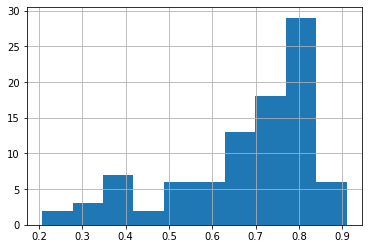

In [35]:
t.data_test['prediction'].hist()

# Active Learning (Apenas um teste)

In [ ]:
from scipy import stats
class active_learning(Judger):
  def __init__(self, data):
    self.data = data
    # print(self.data['label'])
    super(active_learning, self).__init__(data = self.data, configure_text=False)
    
    
 
  def __call__(self):
    clear_output()
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # print(self.data)

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0:
      return print('Finish')

    # Index aleatorio para selecionar um texto para classificacao
    unlabeled_data = self.data.loc[criteria_na]
    indexs_unlabeled = unlabeled_data.index
    
    prediction_unlabeled = unlabeled_data.loc[:, 'prediction']
    # prob = poisson.cdf(indexs_unlabeled, mu=1)
    
    kernel = stats.gaussian_kde(prediction_unlabeled)
    
    prob = kernel(prediction_unlabeled) / sum( kernel(prediction_unlabeled))


    self.index = np.random.choice(indexs_unlabeled, 1,
                                  replace=False,
                                  p = prob
                                  ).item()

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index aleatorio
    text = self.data.loc[self.index, 'text']
    label = self.data.loc[self.index, 'label']
    prediction = self.data.loc[self.index, 'prediction']
    
    
    # Print de alguns resultados
    print('Unlabed:', sum(criteria_na))
    print(
          "Not included examples:", self.excluded_count,"|",
          "Included examples:", self.included_count)
    display(self.hbox)
    
    print('Prediction:', prediction)
    # print('Included:', self.treshold <= prediction)

    print('Previos Label:', label)
    print('Text:')
    display(Markdown(text))



In [ ]:
ranked_test_data['label'] = np.nan

ac = active_learning(data = ranked_test_data)

ac()

Unlabed: 92
Not included examples: 0 | Included examples: 0


Prediction: 0.60040444
Previos Label: nan
Text:


Deep learning COVID-19 detection bias: accuracy through artificial intelligence. Background Detection of COVID-19 cases’ accuracy is posing a conundrum for scientists, physicians, and policy-makers. As of April 23, 2020, 2.7 million cases have been confirmed, over 190,000 people are dead, and about 750,000 people are reported recovered. Yet, there is no publicly available data on tests that could be missing infections. Complicating matters and furthering anxiety are specific instances of false-negative tests. Methods We developed a deep learning model to improve accuracy of reported cases and to precisely predict the disease from chest X-ray scans. Our model relied on convolutional neural networks (CNNs) to detect structural abnormalities and disease categorization that were keys to uncovering hidden patterns. To do so, a transfer learning approach was deployed to perform detections from the chest anterior-posterior radiographs of patients. We used publicly available datasets to achieve this. Results Our results offer very high accuracy (96.3%) and loss (0.151 binary cross-entropy) using the public dataset consisting of patients from different countries worldwide. As the confusion matrix indicates, our model is able to accurately identify true negatives (74) and true positives (32); this deep learning model identified three cases of false-positive and one false-negative finding from the healthy patient scans. Conclusions Our COVID-19 detection model minimizes manual interaction dependent on radiologists as it automates identification of structural abnormalities in patient’s CXRs, and our deep learning model is likely to detect true positives and true negatives and weed out false positive and false negatives with > 96.3% accuracy.